In [3]:
!pip install mthree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 53.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 1.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 195.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 70.5 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.4.2
    Uninstalling websocket-client-1.4.2:
      Successfully uninstalled websocket-client-1.4.2
  Attempting uninstall: cython
    Found existing installation: Cython 0.29.32
    Uninstalling Cython-0.29.32:
      Successfully uninstalled Cython-0.29.32
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
quantum-serverless 0.9.0 requires

In [4]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit
from qiskit_aer.noise import NoiseModel, ReadoutError
from qiskit_aer import AerSimulator
from qiskit.result import sampled_expectation_value
from qiskit.quantum_info import SparsePauliOp

from qiskit.visualization import plot_histogram

import mthree

We shall create a Generic Backend with the noise model of ibm_kyoto

In [5]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime import QiskitRuntimeService

In [15]:
service = QiskitRuntimeService()
bcknd = service.get_backend('ibm_kyoto')

qiskit_runtime_service.__init__:INFO:2024-03-15 04:24:53,494: Default instance: ibm-q-internal/performance/demos


In [16]:
noise_model = NoiseModel.from_backend(bcknd)

In [17]:
backend = GenericBackendV2(
    num_qubits=bcknd.num_qubits,
    basis_gates=bcknd.configuration().basis_gates,
    coupling_map=bcknd.configuration().coupling_map
)
backend.set_options(**{'noise_model':noise_model})

In [18]:
from numpy.random import default_rng
from numpy import pi
from qiskit.circuit import Parameter, ParameterVector


def build_qaoa_circuit(
        num_qubits: int, 
        depth: int, 
        measurements: bool = True, 
        barriers: bool = False, 
) -> QuantumCircuit:
    """Build parameterized QAOA quantum circuit.
    
    Args:
        num_qubits: number of qubits.
        depth: two-qubit depth (needs to be even).
        measurements: if True adds measurements at the end.
        barriers: if True adds barriers between layers.
    Returns:
        A dense QAOA quantum circuit for a linear, non-cyclic, graph
        with cost parameter-vector γ, and mixer parameter-vector β.
    """
    if num_qubits <= 2:
        raise ValueError("Number of qubits must be greater than two.")
    if depth % 2 != 0:
        raise ValueError("Depth must be even.")
    
    gammas = ParameterVector('γ', depth // 2) 
    betas = ParameterVector('β', depth // 2)

    circuit = QuantumCircuit(num_qubits)
    circuit.h(range(num_qubits))
    for layer in range(depth // 2):
        if barriers:
            circuit.barrier()
        for qubit in range(0, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(1, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(num_qubits):
            circuit.rx(betas[layer], qubit)
    
    if measurements:
        circuit.measure_all()
    return circuit


def produce_qaoa_parameters(num_layers, *, seed=None):
    """Produce random QAOA parameters.
    Args:
        num_layers: the number of QAOA layers.
        seed: a seed to generate the random angles.
    Returns:
        A tuple holding the beta and gamma angles.
    """
    rng = default_rng(seed=seed)
    betas = rng.uniform(-pi, pi, size=num_layers).tolist()
    gammas = rng.uniform(-pi, pi, size=num_layers).tolist()
    return betas, gammas


def build_compute_uncompute_qaoa_circuit(
        num_qubits: int, 
        depth: int, 
        *,
        measurements: bool = True, 
        barriers: bool = False, 
    ) -> QuantumCircuit:
    """Build a parametrized compute-uncompute QAOA quantum circuit."""
    if depth % 4 != 0:
       raise ValueError("Depth must be a multiple of four.")

    qaoa = build_qaoa_circuit(num_qubits, depth // 2, measurements=False, barriers=barriers)
    
    circuit = QuantumCircuit(num_qubits)
    circuit.compose(qaoa, inplace=True)
    circuit.barrier()
    circuit.compose(qaoa.inverse(), inplace=True)
    if measurements:
        circuit.measure_all(inplace=True)
    
    return circuit

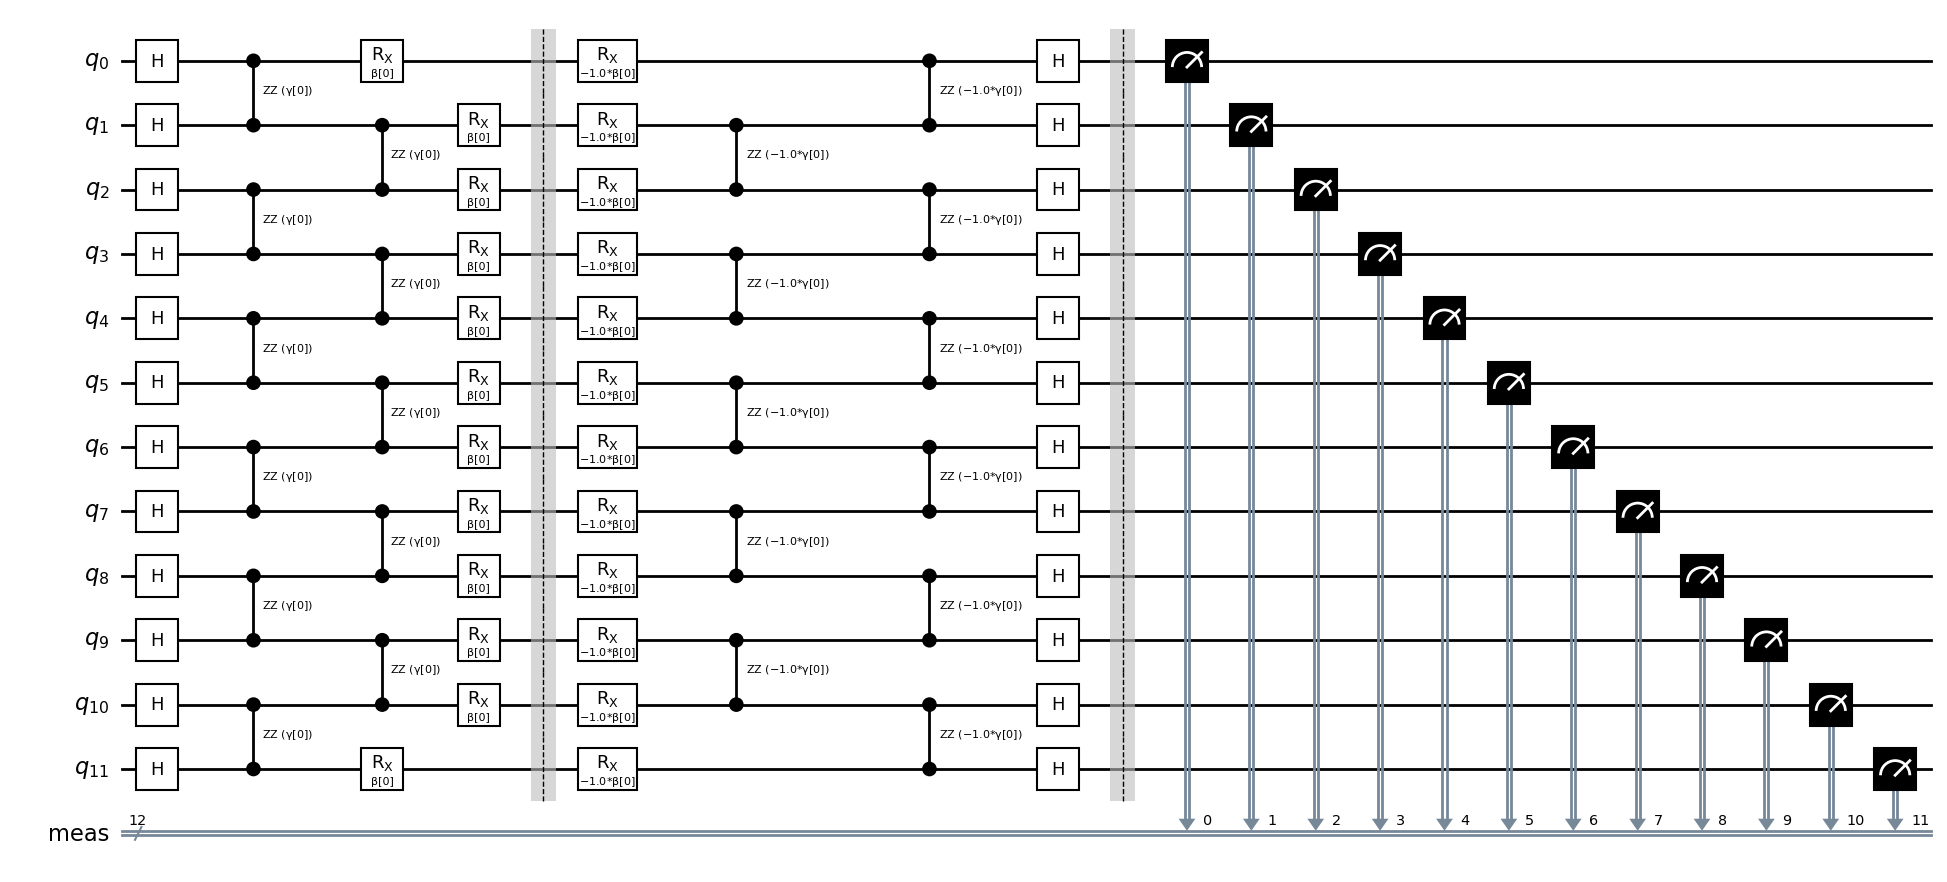

In [19]:
num_qubits = 12
p = 1
qc = build_compute_uncompute_qaoa_circuit(num_qubits,4*p)
qc.draw('mpl',style='bw',fold=-1)

In [20]:
betas, gammas = produce_qaoa_parameters(1, seed=0)
params = [gammas[0], betas[0]]
params

[-1.4464727375963786, 0.8605556614246863]

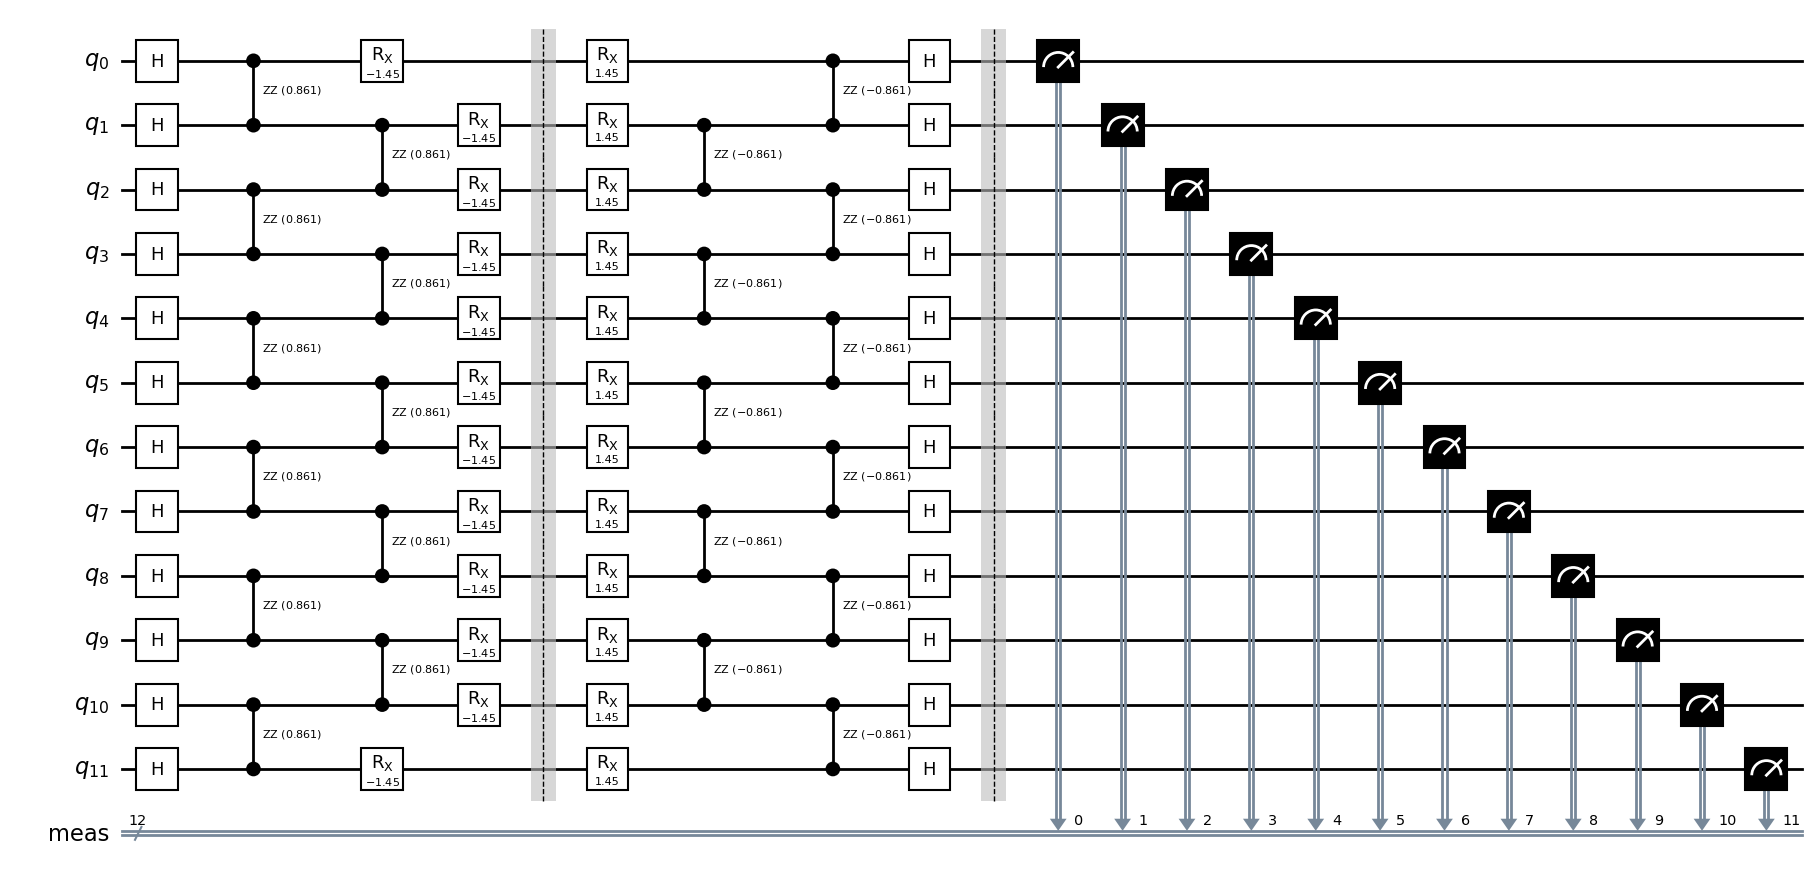

In [21]:
qc = qc.assign_parameters(params)
qc.draw('mpl',style='bw',fold=-1)

In [27]:
shots = 10000
observables = []

# Considering only wt-1 observables for brevity
for i in range(num_qubits):
    obs = 'I'*i + 'Z'*1 + 'I'*(num_qubits-i-1)
    observables.append(obs)

observables

['ZIIIIIIIIIII',
 'IZIIIIIIIIII',
 'IIZIIIIIIIII',
 'IIIZIIIIIIII',
 'IIIIZIIIIIII',
 'IIIIIZIIIIII',
 'IIIIIIZIIIII',
 'IIIIIIIZIIII',
 'IIIIIIIIZIII',
 'IIIIIIIIIZII',
 'IIIIIIIIIIZI',
 'IIIIIIIIIIIZ']

In [22]:
qubits = [1,2,3,4,5,6,7,8,9,10,11,12]

In [23]:
mit = mthree.M3Mitigation(backend)
mit.cals_from_system(qubits)

In [24]:
cals = mit.cals_to_matrices()
cals

[None,
 array([[0.9988, 0.0021],
        [0.0012, 0.9979]]),
 array([[0.9962, 0.005 ],
        [0.0038, 0.995 ]]),
 array([[0.9963, 0.0026],
        [0.0037, 0.9974]]),
 array([[0.9987, 0.0014],
        [0.0013, 0.9986]]),
 array([[0.9962, 0.0046],
        [0.0038, 0.9954]]),
 array([[9.993e-01, 3.000e-04],
        [7.000e-04, 9.997e-01]]),
 array([[0.9951, 0.0065],
        [0.0049, 0.9935]]),
 array([[0.9979, 0.0033],
        [0.0021, 0.9967]]),
 array([[9.995e-01, 1.600e-03],
        [5.000e-04, 9.984e-01]]),
 array([[0.9971, 0.0034],
        [0.0029, 0.9966]]),
 array([[0.9971, 0.0038],
        [0.0029, 0.9962]]),
 array([[0.9989, 0.0014],
        [0.0011, 0.9986]]),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

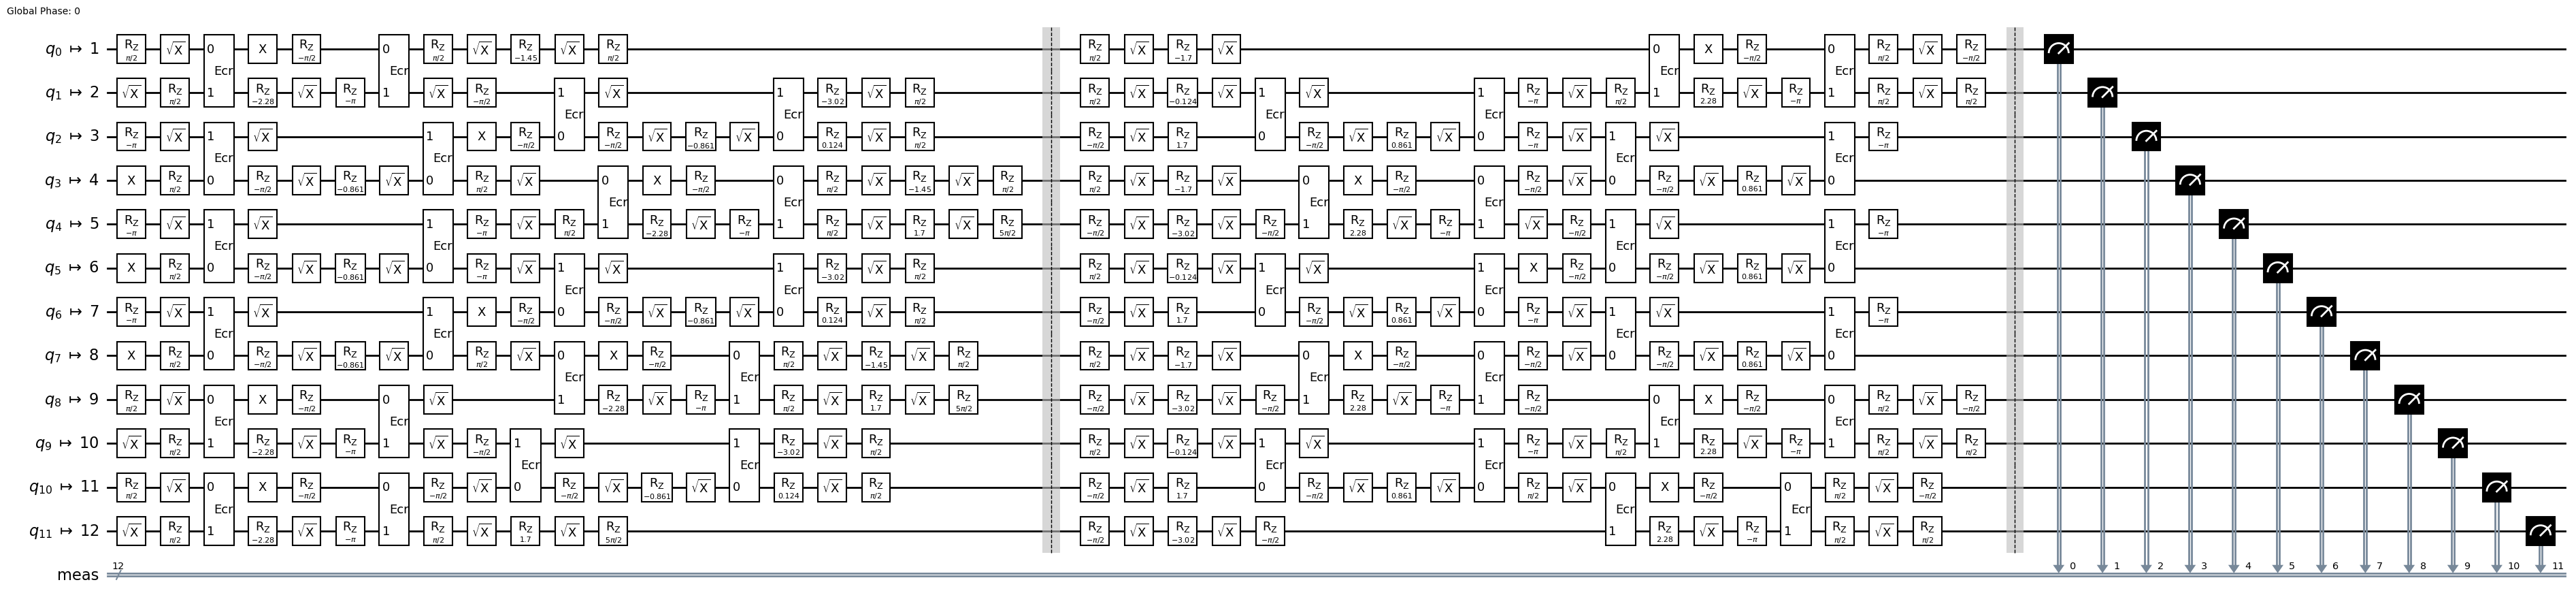

In [25]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(2, backend, initial_layout=qubits)

qc = pm.run(qc)
qc.draw('mpl',style='bw',idle_wires=False, fold=-1)

In [28]:
counts_noisy = backend.run(qc,shots=shots).result().get_counts()

if sum(counts_noisy.values()) != 1:
    for key, val in counts_noisy.items():
        counts_noisy[key] = val/shots

In [29]:
A_mat_full, _ = mit.reduced_cal_matrix(counts_noisy,qubits)
A_mat_full

array([[9.71573870e-01, 2.06228926e-03, 4.91267981e-03, ...,
        6.02035159e-11, 2.89084302e-11, 1.90035189e-13],
       [1.16728939e-03, 9.79980213e-01, 5.90229853e-06, ...,
        7.23310163e-14, 3.47317944e-14, 2.28316206e-16],
       [3.70606375e-03, 7.86659222e-06, 9.77623282e-01, ...,
        2.29646015e-13, 1.10271065e-13, 7.24888292e-16],
       ...,
       [1.90457173e-11, 4.04269602e-14, 9.63030334e-14, ...,
        9.96645720e-01, 3.33445771e-06, 2.19197063e-08],
       [4.52743545e-12, 9.61005825e-15, 2.28925884e-14, ...,
        1.65073551e-06, 9.88729590e-01, 6.49960626e-03],
       [2.22936727e-14, 4.73211591e-17, 1.12726041e-16, ...,
        8.12843332e-09, 4.86863129e-03, 9.93439818e-01]])

In [30]:
A_mat_3, _ = mit.reduced_cal_matrix(counts_noisy,qubits, distance=3)
A_mat_3

array([[9.71573870e-01, 2.06228926e-03, 4.91267982e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.16728939e-03, 9.79980214e-01, 5.90229854e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.70606375e-03, 7.86659223e-06, 9.77623284e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.96645721e-01, 3.33445772e-06, 2.19197063e-08],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65073551e-06, 9.88729591e-01, 6.49960627e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.12843333e-09, 4.86863129e-03, 9.93439820e-01]])

In [31]:
quasi_full = mit.apply_correction(counts_noisy, qubits)

In [32]:
quasi_d3 = mit.apply_correction(counts_noisy, qubits, distance=3)

In [33]:
import numpy as np

quasis = {
    dist: mit.apply_correction(counts_noisy, qubits, distance=dist)
    for dist in range(1,num_qubits+1)
}

In [ ]:
mitigated_expval = {}

for dist in range(1,num_qubits+1):
    expvals = []
    for obs in observables:
        expvals.append(sampled_expectation_value(quasis[dist],obs))
    mitigated_expval[dist] = expvals

In [18]:
rmse = []

for dist in range(1,num_qubits+1):
    expvals = mitigated_expval[dist]
    actual = [1]*len(expvals)
    mse = np.square(np.subtract(expvals,actual)).mean()
    rmse.append(np.sqrt(mse))

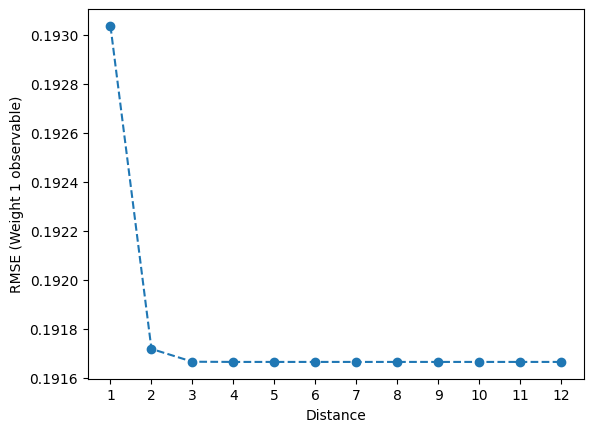

In [19]:
import matplotlib.pyplot as plt

plt.plot(range(1,num_qubits+1), rmse, 'o--')
plt.ylabel('RMSE (Weight 1 observable)')
plt.xlabel('Distance')
plt.xticks(range(1,num_qubits+1))
plt.show()